# Food Delivery Time Prediction - Analysis

---

# Setup

As a first step, we import the necessary libraries and tools.

In [487]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from scipy.stats import chi2_contingency

from ISLP import load_data
from ISLP.models import (ModelSpec as MS ,summarize, poly)

from functools import partial
from sklearn.model_selection import (cross_validate ,KFold ,ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm
from sklearn.model_selection import train_test_split


The dataset _Food_Delivery_Times_ is imported from the Git directory.  
After examining the contents of the database, we observe the presence of null values. It has been decided to remove these rows.  
Null values are removed because they can interfere with the calculations of the model, leading to inaccurate results.

In [488]:
Food = pd.read_csv("dataset/Food_Delivery_Times.csv")
print("Number of rows in the original dataset:", len(Food))

null_rows = Food.isnull().any(axis=1).sum()
print("Number of rows with missing values:", null_rows)

Food = Food.dropna()
print("Number of rows after removing missing values:", len(Food))

Food.head()


Number of rows in the original dataset: 1000
Number of rows with missing values: 117
Number of rows after removing missing values: 883


,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


Outliers are extreme values that can distort analysis and lead to misleading results.  
We used the Interquartile Range (IQR) method to detect and remove them.  
This ensures cleaner data and more reliable outcomes in the following analyses.


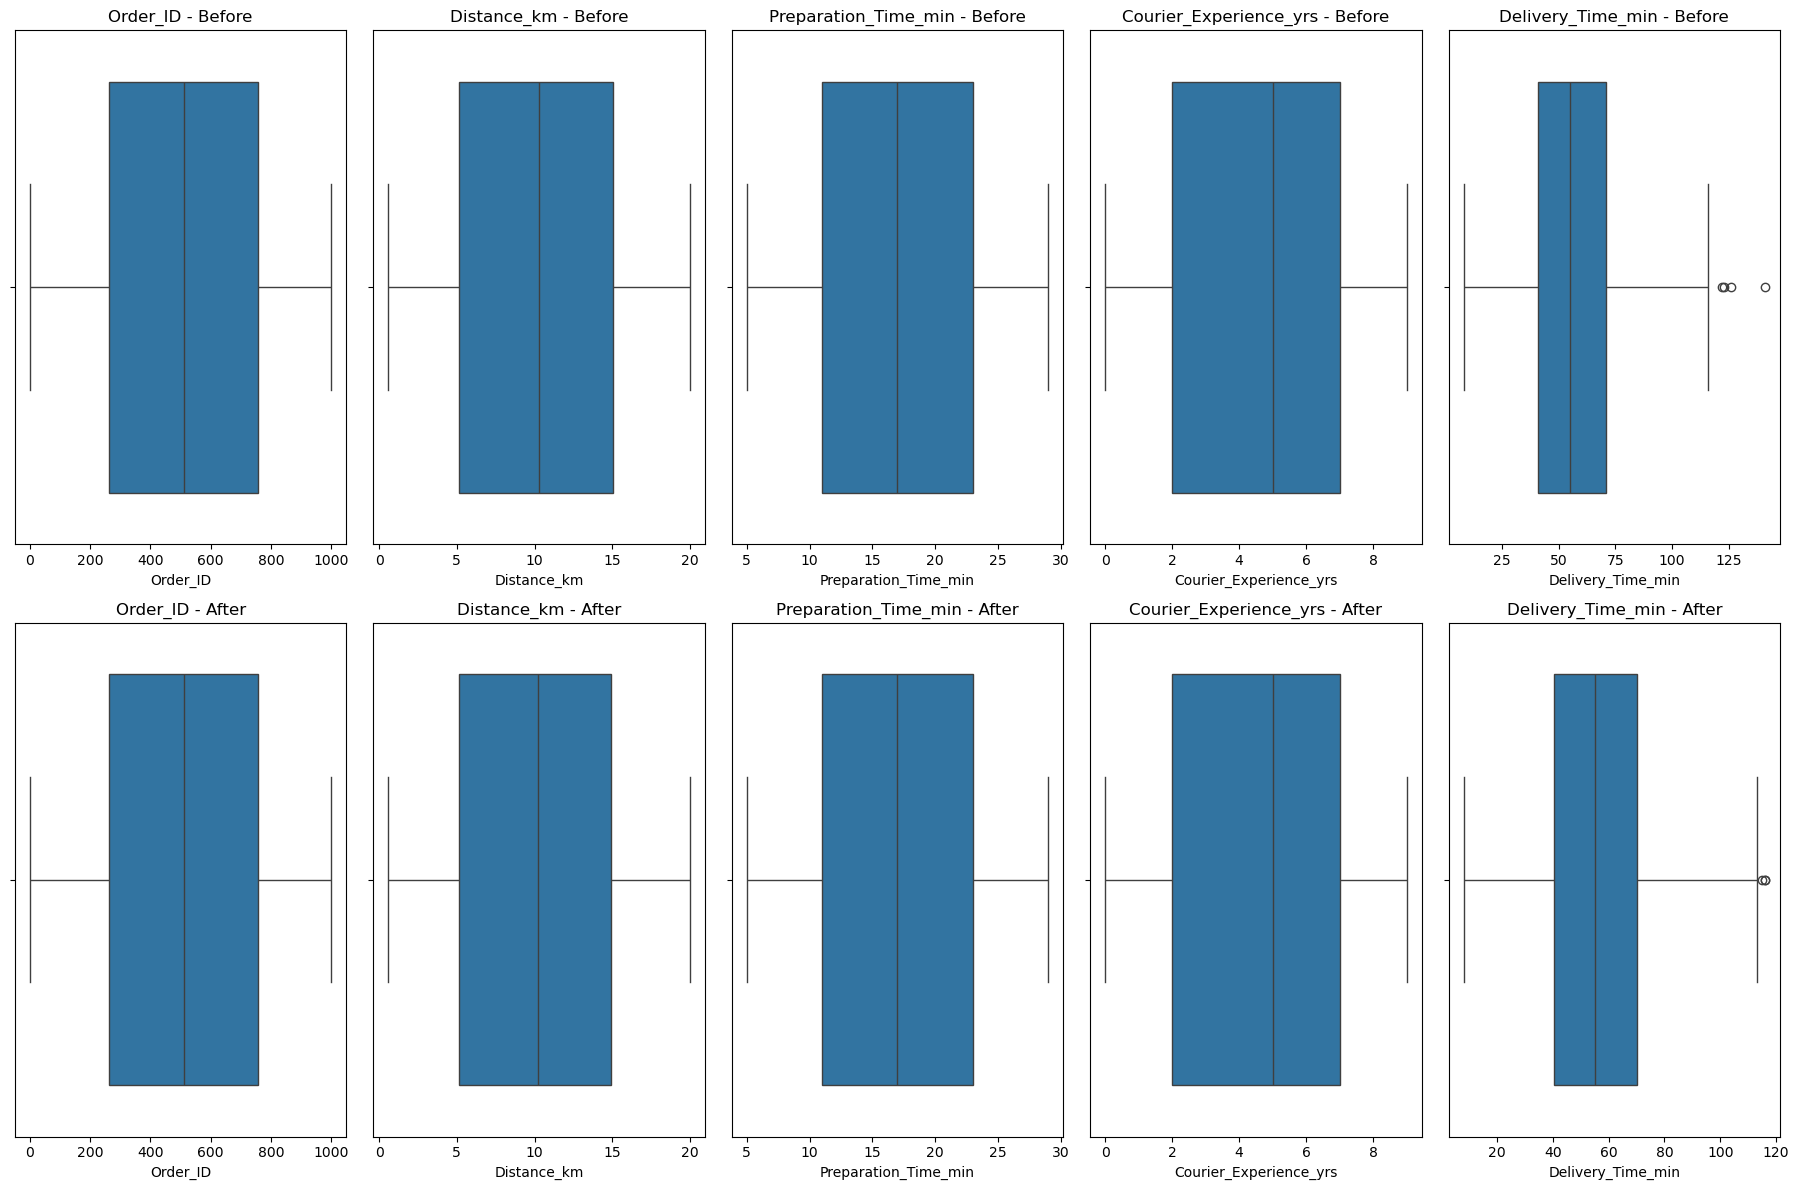

Number of rows after removing outliers 879


In [489]:
numeric_columns = Food.select_dtypes(include=['float64', 'int64']).columns

Food_original = Food.copy()

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in numeric_columns:
    Food = remove_outliers(Food, col)

plt.figure(figsize=(18, 12))
for i, col in enumerate(numeric_columns, 1):

    plt.subplot(2, len(numeric_columns), i)
    sns.boxplot(x=Food_original[col])
    plt.title(f"{col} - Before")

    plt.subplot(2, len(numeric_columns), len(numeric_columns) + i)
    sns.boxplot(x=Food[col])
    plt.title(f"{col} - After")

plt.tight_layout()
plt.show()

print("Number of rows after removing outliers", len(Food))


The boxplots show the distribution of numerical variables before and after outlier removal.  
The dataset shows good quality as it contains few outliers.
Extreme points, especially in Delivery_Time_min, were removed, making the data more compact.  
The cleaned data is now more consistent and less influenced by rare or abnormal values.

---

# Simple Linear Regression

Before building regression models, we assess the quality of the dataset by analyzing the correlation between variables through the construction of a correlation matrix.  

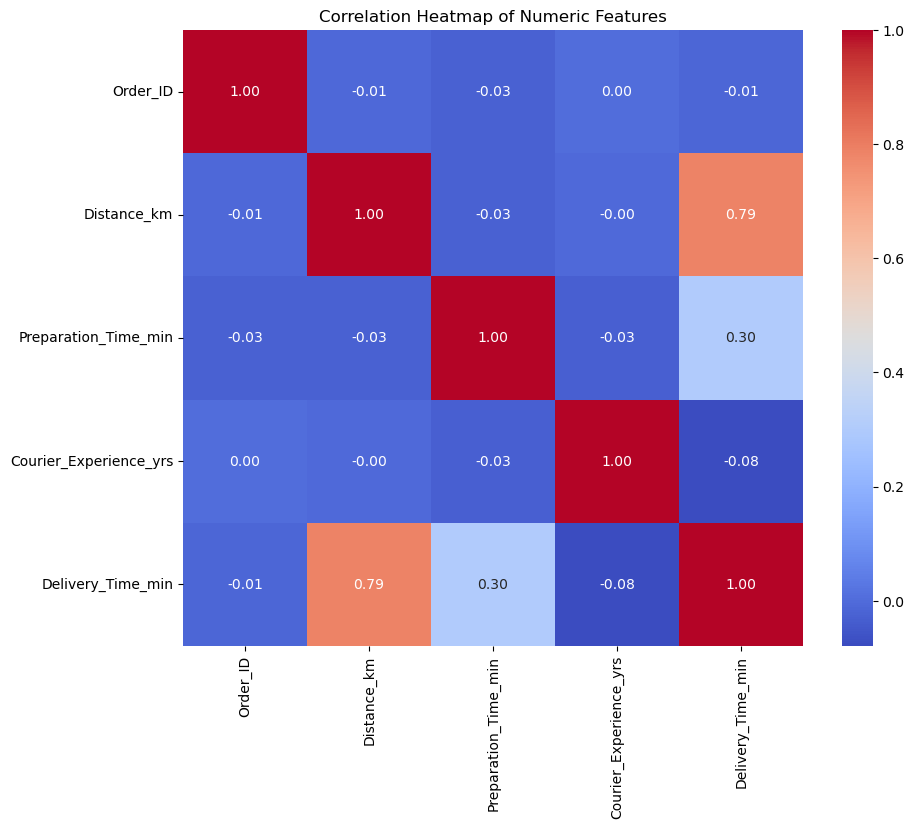

In [490]:
numeric_df = Food.select_dtypes(include=[np.number])

if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(10, 8))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()


In our case, some variables show a clear linear relationship with delivery time, indicating their potential importance in the regression model.  
Additionally, the predictors are not highly correlated with each other, suggesting that the dataset is suitable for linear regression and that multicollinearity is not a concern.


The three numerical variables (_Distance_km_, _Preparation_Time_min_, _Courier_Experience_yrs_) are selected, and the relationship between each of them and the response variable _Delivery_Time_min_ is analyzed individually.  
The variable _Order_ID_ is completely irrelevant to our objective, so we do not take it into account.

-  ## First case: 
#### _Delivery_Time_min_ = _b0_ + _b1_ * _Distance_km_ + _e_

In [491]:
X = pd.DataFrame({'intercept': np.ones(Food.shape[0]), 'Distance_km': Food['Distance_km']})
X[:4]

,intercept,Distance_km
0,1.0,7.93
1,1.0,16.42
2,1.0,9.52
3,1.0,7.44


In [492]:
y = Food['Delivery_Time_min']
model = sm.OLS(y, X) 
results = model.fit() 
summarize(results)

,coef,std err,t,P>|t|
intercept,26.8673,0.890,30.184,0.0
Distance_km,2.9180,0.077,37.746,0.0


_Distance_km_ has a p-value of 0.0, indicating that it is highly significant.  
The coefficient is positive, meaning that as the distance increases, the waiting time also increases.  
The intercept is high, suggesting that distance alone does not sufficiently explain the delivery times.  

### Model prediction and confidence intervals

We define a linear regression design matrix including an intercept and the explanatory variable _Distance_km_ using the ModelSpec class from ISLP.  
This allows for consistent and automatic construction of the design matrix for both the original dataset and new observations.  

We then generate predictions and 95% confidence intervals for new values of _Distance_km_ based on the previously fitted model.


In [493]:
model = MS(['Distance_km'])
model = model.fit(Food) 
X = model.transform(Food)
X[:4]

,intercept,Distance_km
0,1.0,7.93
1,1.0,16.42
2,1.0,9.52
3,1.0,7.44


In [494]:
new_df = pd.DataFrame({'Distance_km':[10, 12, 14, 16, 20]})
newX = model.transform(new_df) 
newX

,intercept,Distance_km
0,1.0,10
1,1.0,12
2,1.0,14
3,1.0,16
4,1.0,20


In [495]:
new_predictions = results.get_prediction(newX)
new_predictions.predicted_mean

array([56.047364  , 61.88336722, 67.71937045, 73.55537368, 85.22738013])

In [496]:
new_predictions.conf_int(alpha=0.05)

array([[55.18622211, 56.90850588],
       [60.97123424, 62.79550021],
       [66.66742956, 68.77131134],
       [72.30423639, 74.80651096],
       [83.48514315, 86.96961711]])

These intervals suggest that the model provides reasonably tight estimates for the predicted waiting times, with relatively small ranges around each predicted value.  
This indicates a good level of precision in the model's predictions.


### Graphs

1. #### Regression line

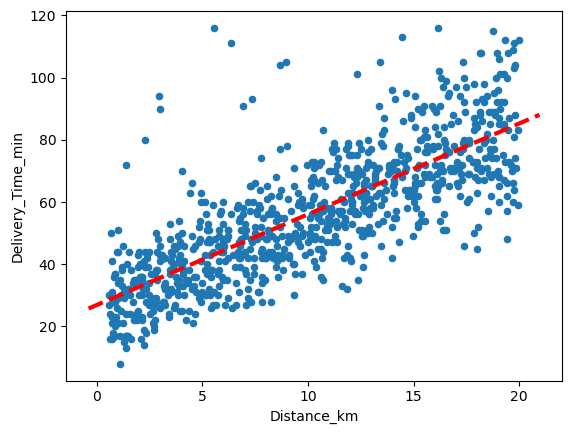

In [497]:
def abline(ax, b, m, *args, **kwargs):
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

ax = Food.plot.scatter('Distance_km', 'Delivery_Time_min')
abline(ax, results.params.iloc[0], results.params.iloc[1], 'r--', linewidth=3)

The scatter plot shows a positive correlation between distance in kilometers and delivery time in minutes.  
The data points align well with the linear trend line, indicating that the model is accurate and useful for predicting delivery times based on distance.

2. #### Fitted values vs residuals

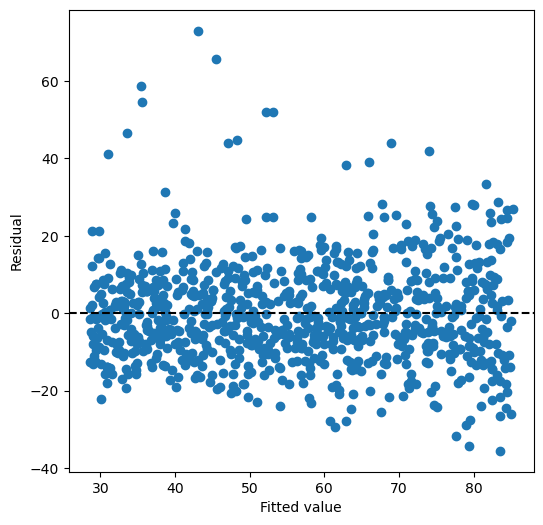

In [498]:
fig, ax = plt.subplots(figsize=(6, 6)) 
ax.scatter(results.fittedvalues, results.resid)  
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')   

The residuals are spread around the zero line, indicating that the model fits the data well.  
There are no clear patterns in the residuals, suggesting the model's assumptions about linearity are valid.

3. #### Leverage

np.int64(354)

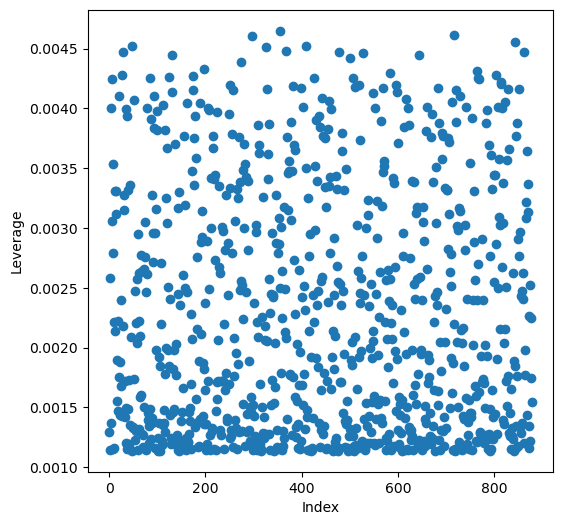

In [499]:
infl = results.get_influence()
ax = plt.subplots(figsize=(6, 6))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)


The leverage values are low, meaning no single data point has too much impact on the model.  
The leverage level for outliers is 0.0045. Since almost all data points are below this threshold, the model is well-balanced.


-  ## Second case: 
#### _Delivery_Time_min_ = _b0_ + _b1_ * _Preparation_Time_min_ + _e_

In [500]:
X = pd.DataFrame({'intercept': np.ones(Food.shape[0]), 'Preparation_Time_min': Food['Preparation_Time_min']})
X[:4]

,intercept,Preparation_Time_min
0,1.0,12
1,1.0,20
2,1.0,28
3,1.0,5


In [501]:
y = Food['Delivery_Time_min']
model = sm.OLS(y, X) 
results = model.fit() 
summarize(results)

,coef,std err,t,P>|t|
intercept,41.2948,1.727,23.913,0.0
Preparation_Time_min,0.8703,0.093,9.322,0.0


_Preparation_Time_min_ has a p-value of 0.0, indicating that it is highly significant.  
The coefficient is positive, meaning that as the preparation time increases, the waiting time also increases.  
The intercept is relatively high, suggesting that preparation time alone does not fully explain the total waiting time.  

### Model prediction and confidence intervals

In [502]:
model = MS(['Preparation_Time_min'])
model = model.fit(Food) 
X = model.transform(Food)
X[:4]

,intercept,Preparation_Time_min
0,1.0,12
1,1.0,20
2,1.0,28
3,1.0,5


In [503]:
new_df = pd.DataFrame({'Preparation_Time_min':[10, 12, 14, 16, 20]})
newX = model.transform(new_df)
newX

,intercept,Preparation_Time_min
0,1.0,10
1,1.0,12
2,1.0,14
3,1.0,16
4,1.0,20


In [504]:
new_predictions = results.get_prediction(newX)
new_predictions.predicted_mean

array([49.99800226, 51.73863378, 53.47926529, 55.21989681, 58.70115983])

In [505]:
new_predictions.conf_int(alpha=0.05)

array([[48.14830241, 51.84770211],
       [50.12183792, 53.35542964],
       [52.03868239, 54.91984819],
       [53.87634173, 56.56345188],
       [57.26216877, 60.1401509 ]])

These intervals indicate that the model produces slightly less accurate predictions for the waiting times than the previous model, with larger ranges surrounding each predicted value.  
This suggests that the model has a good degree of precision in its estimates.



### Graphs

1. #### Regression line

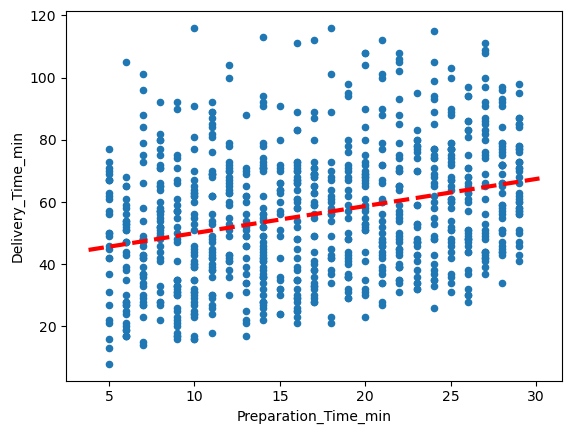

In [506]:
def abline(ax, b, m, *args, **kwargs):
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

ax = Food.plot.scatter('Preparation_Time_min', 'Delivery_Time_min')
abline(ax, results.params.iloc[0], results.params.iloc[1], 'r--', linewidth=3)

The scatter plot shows a positive correlation between preparation time and delivery time in minutes.  
The data points generally align with the linear trend line, suggesting that the model is reasonably good.  
However, compared to the previous model, the dispersion of the data points appears to increase.  
Additionally, there is noticeable vertical overlap between points at similar time values, indicating that other factors beyond distance may also influence delivery times.


2. #### Fitted values vs residuals

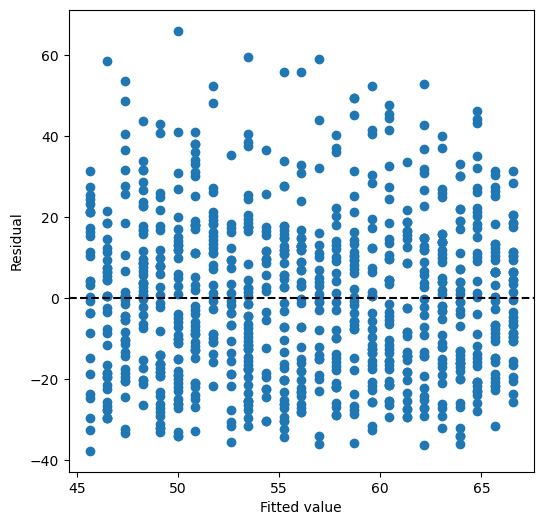

In [507]:
fig, ax = plt.subplots(figsize=(6, 6)) 
ax.scatter(results.fittedvalues, results.resid)  
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');  

The residuals appear to be fairly symmetrically distributed above and below the zero line, which supports the assumption of linearity in the model.  
However, the residuals are widely spread, showing a noticeable vertical dispersion.

3. #### Leverage

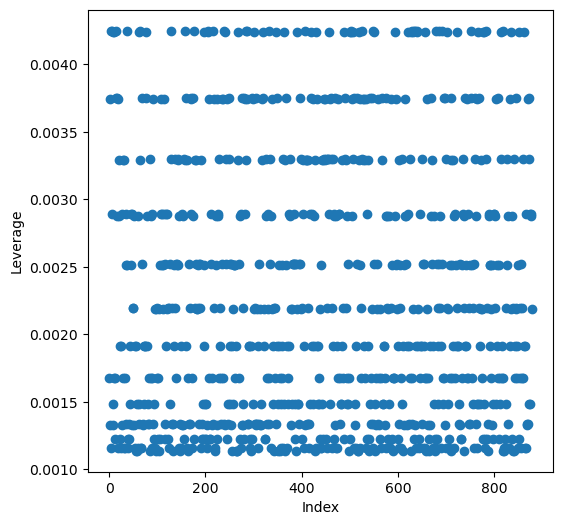

In [508]:
infl = results.get_influence()
ax = plt.subplots(figsize=(6, 6))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag);

Leverage values across the dataset are low, indicating that no individual observation exerts excessive influence on the model's predictions.  
The threshold for high leverage is 0.0045, and all points fall below this value.  
From this point of view, the model is very good.


-  ## Third case: 
#### _Delivery_Time_min_ = _b0_ + _b1_ * _Courier_Experience_yrs_ + _e_

In [509]:
X = pd.DataFrame({'intercept': np.ones(Food.shape[0]), 'Courier_Experience_yrs': Food['Courier_Experience_yrs']})
X[:4]

,intercept,Courier_Experience_yrs
0,1.0,1.0
1,1.0,2.0
2,1.0,1.0
3,1.0,1.0


In [510]:
y = Food['Delivery_Time_min']
model = sm.OLS(y, X) 
results = model.fit() 
summarize(results)

,coef,std err,t,P>|t|
intercept,58.7422,1.328,44.222,0.000
Courier_Experience_yrs,-0.5695,0.242,-2.352,0.019


_Courier_Experience_yrs_ has a p-value of 0.022, indicating that it is significant.  
The coefficient is negative, meaning that as courier experience increases, the waiting time tends to decrease.  
The intercept is relatively high, suggesting that courier experience alone does not fully account for the variability in waiting times.  
Compared to the previous models, _Courier_Experience_yrs_ has a smaller effect size and slightly higher uncertainty, as reflected in the standard error and t-statistic.


### Model prediction and confidence intervals

In [511]:
model = MS(['Courier_Experience_yrs'])
model = model.fit(Food)
X = model.transform(Food)
X[:4]

,intercept,Courier_Experience_yrs
0,1.0,1.0
1,1.0,2.0
2,1.0,1.0
3,1.0,1.0


In [512]:
new_df = pd.DataFrame({'Courier_Experience_yrs':[1, 3, 5, 7, 10]})
newX = model.transform(new_df)
newX

,intercept,Courier_Experience_yrs
0,1.0,1
1,1.0,3
2,1.0,5
3,1.0,7
4,1.0,10


In [513]:
new_predictions = results.get_prediction(newX)
new_predictions.predicted_mean

array([58.1727115 , 57.03372218, 55.89473287, 54.75574356, 53.04725959])

In [514]:
new_predictions.conf_int(alpha=0.05)

array([[55.95314347, 60.39227952],
       [55.43959247, 58.62785189],
       [54.49350217, 57.29596357],
       [52.96882553, 56.54266159],
       [50.14442453, 55.95009465]])

The intervals show that the model generates fairly precise predictions for the waiting times, with usually small variations around each predicted value.  
This reflects a decent level of accuracy in the model's forecasts.


### Graphs

1. #### Regression line

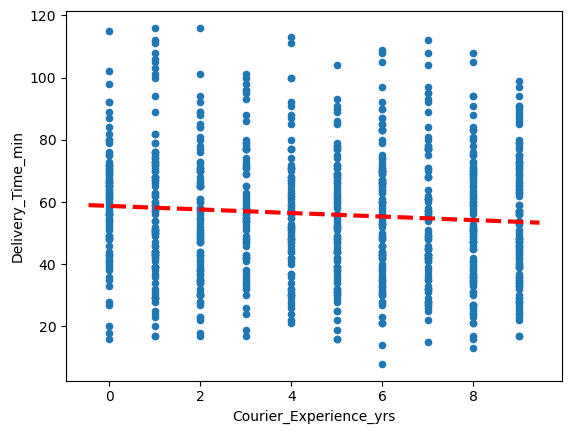

In [515]:
def abline(ax, b, m, *args, **kwargs):
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

ax = Food.plot.scatter('Courier_Experience_yrs', 'Delivery_Time_min')
abline(ax, results.params.iloc[0], results.params.iloc[1], 'r--', linewidth=3)

The plot shows that the trend line is slightly downward, indicating a weak negative relationship between preparation time and delivery time.  
The data points are highly dispersed around the trend line, suggesting that the model does not adequately explain the variability in the data.  
Additionally, there is considerable vertical overlap between the points, which indicates that factors beyond experience may significantly influence delivery times.  
This suggests the possibility of a nonlinear relationship, and the model is likely the worst one so far.


2. #### Fitted values vs residuals

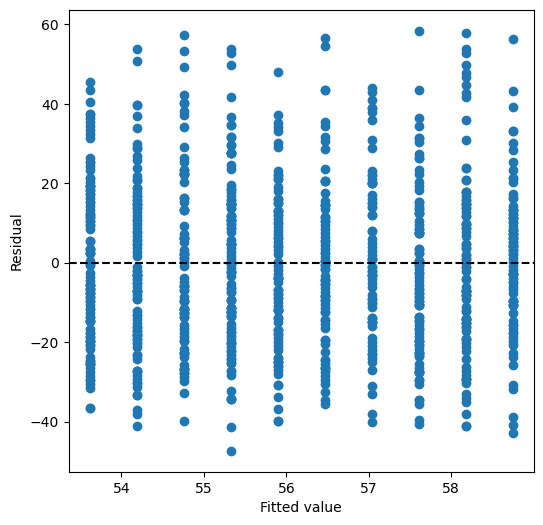

In [516]:
fig, ax = plt.subplots(figsize=(6, 6)) 
ax.scatter(results.fittedvalues, results.resid)  
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

In this case as well, the residuals are symmetric but very large, indicating poor accuracy.

3. #### Leverage

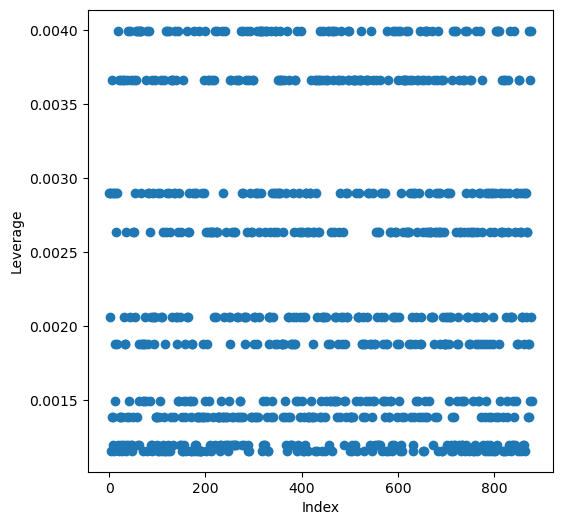

In [517]:
infl = results.get_influence()
ax = plt.subplots(figsize=(6, 6))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag);

No point has high leverage, meaning no single point dominates the model's estimation.  
This is positive, but it also confirms that no single observation provides strong information to the model, which is consistent with the fact that the model does not adequately explain the variability in the data.


---

# Multiple Linear Regression
- ## Numerical predictors
#### _Delivery_Time_min_ = _b0_ + _b1_ * _Distance_km_ + _b2_ * _Preparation_Time_min_ + _b3_ * _Courier_Experience_yrs_ + _e_

In [518]:
X = MS(['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs']).fit_transform(Food)
y = Food['Delivery_Time_min']

model = sm.OLS(y, X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,13.0071,1.320,9.854,0.0
Distance_km,2.9493,0.066,45.000,0.0
Preparation_Time_min,0.9273,0.051,18.096,0.0
Courier_Experience_yrs,-0.4803,0.127,-3.777,0.0


The results of the linear regression model indicate that distance, preparation time, and courier experience significantly influence food delivery time (p-values = 0).  
Specifically, delivery time increases by approximately 3.00 minutes per additional kilometer.  
It also increases by 1 minutes for each additional minute of preparation.  
In contrast, each additional year of courier experience reduces delivery time by about 0.5 minutes.


In [519]:
print("R2", results.rsquared) 
print("RSE", np.sqrt(results.scale))

R2 0.7269698515442016
RSE 11.024219845632128


The linear regression model explains approximately 73% of the variance in food delivery time, indicating a strong fit.  
The residual standard error (RSE) is 11 minutes, suggesting a moderate prediction error given the likely range of delivery times.  
Overall, the model performs well.

- ## Qualitative predictors

Now we examine the remaining variables, which are categorical.


In [520]:
for col in Food.columns:
    if Food[col].dtype == 'object':
        print(f"{col}: {Food[col].unique()}")

Weather: ['Windy' 'Clear' 'Foggy' 'Rainy' 'Snowy']
Traffic_Level: ['Low' 'Medium' 'High']
Time_of_Day: ['Afternoon' 'Evening' 'Night' 'Morning']
Vehicle_Type: ['Scooter' 'Bike' 'Car']


Before creating the new model, we verify that the categorical variables are not strongly correlated with each other, ensuring that each one contributes useful information to the model.  
Since the variables are not numerical, we cannot use a standard correlation matrix.  
Instead, we use Cramér's V, a statistical measure of association between two categorical variables, which ranges from 0 (no association) to 1 (perfect association).


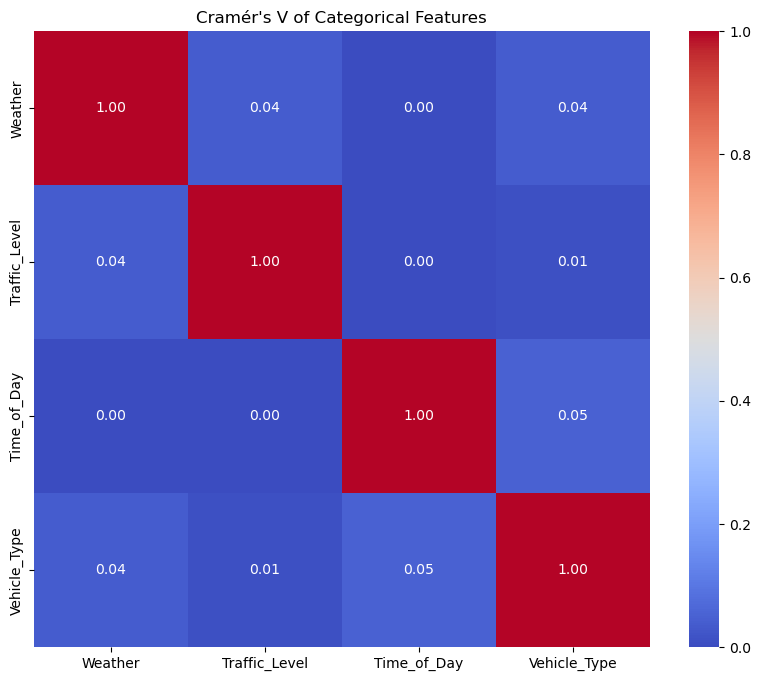

In [521]:
categorical = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']
Food[categorical] = Food[categorical].astype('category')

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1)) 
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

cramer_matrix = pd.DataFrame(
    np.zeros((len(categorical), len(categorical))),
    index=categorical,
    columns=categorical
)

for var1 in categorical:
    for var2 in categorical:
        cramer_matrix.loc[var1, var2] = cramers_v(Food[var1], Food[var2])

plt.figure(figsize=(10, 8))
sns.heatmap(cramer_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Cramér's V of Categorical Features")
plt.show()


The Cramér’s V matrix shows very low values, indicating that the categorical variables are essentially independent from each other.  
No significant associations emerge, suggesting that each variable provides distinct and non-redundant information to the model.


Using the tools from ISLP, we build a regression model that includes all variables, both numerical and categorical.  
Categorical variables are automatically handled by the library through one-hot encoding, a process that transforms each category into a separate binary variable.  
This allows the model to interpret categorical information in a numerical form suitable for linear regression.


In [522]:
model = MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Time_of_Day',
    'Vehicle_Type',
    'Preparation_Time_min',
    'Courier_Experience_yrs'
])

X = model.fit_transform(Food)
y = Food['Delivery_Time_min']

model = sm.OLS(y, X)
results = model.fit()
summarize(results)


,coef,std err,t,P>|t|
intercept,18.4314,1.467,12.564,0.000
Distance_km,2.9055,0.056,51.622,0.000
Weather[Foggy],8.0616,1.059,7.611,0.000
Weather[Rainy],4.9402,0.832,5.938,0.000
Weather[Snowy],10.2738,1.126,9.128,0.000
Weather[Windy],1.9968,1.129,1.769,0.077
Traffic_Level[Low],-12.2613,0.869,-14.102,0.000
Traffic_Level[Medium],-6.0433,0.865,-6.984,0.000
Time_of_Day[Evening],0.0829,0.826,0.100,0.920
Time_of_Day[Morning],-0.8775,0.817,-1.074,0.283


From the regression results, several observations can be made:  
- _Distance_km_ has a strong and significant positive effect on delivery time.  
- Adverse weather conditions like _Foggy_, _Rainy_, and _Snowy_ significantly increase delivery time, compared to _Clear_ weather.  
- _Traffic_Level[Low]_ and _Medium_ significantly reduce delivery time compared to _High_ traffic, which is the baseline.  
- Different times of the day (_Morning_, _Evening_, _Night_) do not show statistically significant differences (p-values > 0.05) from the baseline (_Afternoon_).  
- Similarly, neither _Car_ nor _Scooter_ types show significant differences (p-values > 0.05) from the baseline vehicle (_Bike_), suggesting that vehicle type may not strongly influence delivery time in this model.  
- _Preparation_Time_min_ significantly increases delivery time, as expected.  
- Interestingly, _Courier_Experience_yrs_ is negatively associated with delivery time, indicating that more experienced couriers tend to deliver faster.


In [523]:
print("R2", results.rsquared) 
print("RSE", np.sqrt(results.scale))

R2 0.803281642221906
RSE 9.416991168829025


The linear regression model now explains approximately 80% of the variance in food delivery time, indicating an even stronger fit compared to the previous model (73%).  
The residual standard error is now 10 minutes, suggesting a slight improvement in prediction accuracy, with a lower error compared to the previous model (11 minutes).  
Overall, the model has improved in both explanatory power and prediction accuracy.


Observing the results, we notice that the p-values for _Veicle_Type_ and _Time_of_Day_ are high.  
Before removing them, we aim to better understand why vehicle type does not affect delivery time.  
In real scenarios, using a car should reduce delivery time compared to using a bike.


In [524]:
print(Food['Vehicle_Type'].value_counts())


Vehicle_Type
Bike       450
Scooter    259
Car        170
Name: count, dtype: int64


In [525]:
print(Food.groupby('Vehicle_Type', observed=False)['Delivery_Time_min'].mean())


Vehicle_Type
Bike       56.473333
Car        56.841176
Scooter    54.965251
Name: Delivery_Time_min, dtype: float64


In [526]:
print(Food.groupby('Vehicle_Type', observed=False)['Distance_km'].mean())


Vehicle_Type
Bike       10.001067
Car        10.195471
Scooter     9.931197
Name: Distance_km, dtype: float64


We obtained the following results:  
- As previously mentioned, Cramer's V matrix shows that the association between _Vehicle_Type_ and other categorical variables is nearly nonexistent (maximum value 0.05).  
- The distribution of _Vehicle_Type_ is unbalanced: 450 deliveries by bike, 259 by scooter, and 170 by car, despite this, each group has sufficient size to estimate means robustly.  
- The analysis of average delivery times per vehicle type revealed similar values: 56.47 minutes for bike, 54.96 for scooter, and 56.84 for car.  
- Similarly, the average distance traveled by each vehicle type was nearly the same (around 10 km) and this suggests that vehicle type is not associated with relevant differences in either distance or average time.  

These results justify the high p-value and the absence of effect may indicate that logistic differences between vehicles are offset by other operational factors not included in the dataset (e.g., city routes, assigned paths, traffic, etc.).


We now return to the model and remove, as previously anticipated, _Vehicle_Type_ and _Time_of_Day_


In [527]:
categorical = ['Weather', 'Traffic_Level']
Food[categorical] = Food[categorical].astype('category')

model = MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Preparation_Time_min',
    'Courier_Experience_yrs',
])

X = model.fit_transform(Food)
y = Food['Delivery_Time_min']


model = sm.OLS(y, X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,17.5478,1.348,13.019,0.000
Distance_km,2.9057,0.056,51.668,0.000
Weather[Foggy],8.0511,1.059,7.602,0.000
Weather[Rainy],4.9947,0.831,6.011,0.000
Weather[Snowy],10.4361,1.120,9.318,0.000
Weather[Windy],2.0469,1.126,1.818,0.069
Traffic_Level[Low],-12.2128,0.869,-14.056,0.000
Traffic_Level[Medium],-6.0979,0.865,-7.049,0.000
Preparation_Time_min,0.9446,0.044,21.509,0.000
Courier_Experience_yrs,-0.5510,0.109,-5.040,0.000


In [528]:
print("R2", results.rsquared) 
print("RSE", np.sqrt(results.scale))

R2 0.8019562697725547
RSE 9.421439203442182


By removing the two variables, we obtained a simpler and more interpretable model.  
This was achieved without losing the good performance of the previous full model: R² and RSE values remain nearly identical to before.


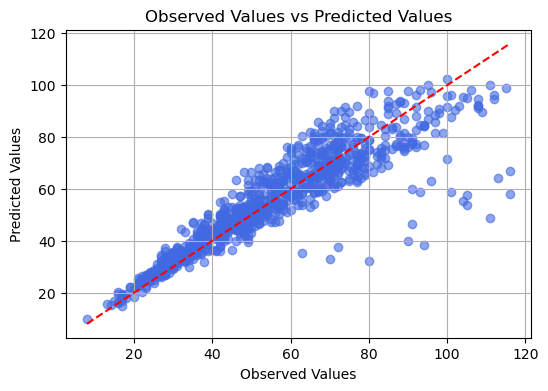

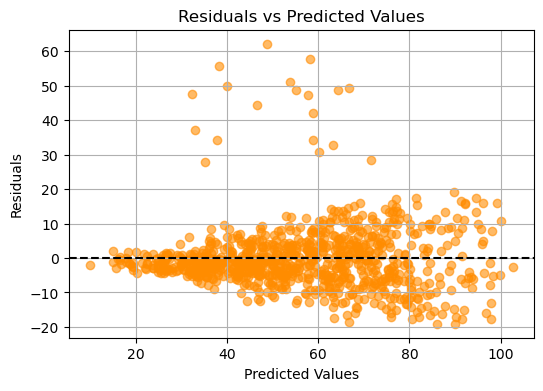

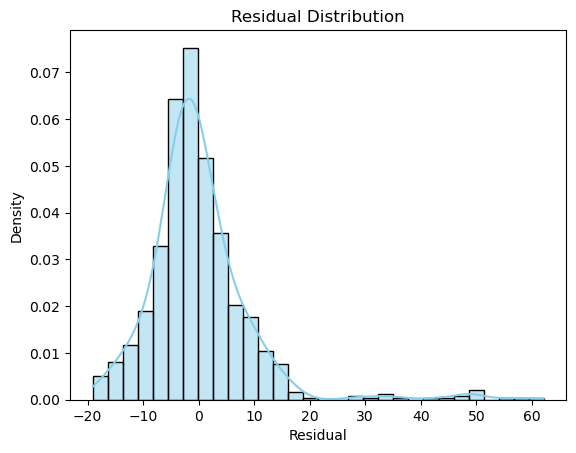

In [529]:
y_pred = results.fittedvalues

plt.figure(figsize=(6, 4))
plt.scatter(y, y_pred, alpha=0.6, color='royalblue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title('Observed Values vs Predicted Values')
plt.grid(True)
plt.show()

residuals = results.resid

plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.6, color='darkorange')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid(True)
plt.show()

sns.histplot(residuals, kde=True, stat="density", color="skyblue", bins=30)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Density")
plt.show()


Observing the graphs, we noticed the presence of outliers.  
To improve the robustness of the regression model, we removed outliers based on the distribution of residuals from an initial OLS fit.  
Residuals are assumed to follow a normal distribution (as confirmed by the previous plot above), and a threshold based on the standard deviation is applied to identify anomalous observations.  
Instead of the conventional ±3 standard deviations, we adopted a slightly more restrictive cutoff of ±2.9 standard deviations.  
This choice allowed us to remove all significant outliers without discarding a substantial portion of the data.  


In [530]:
residuals = results.resid

residuals_std = np.std(residuals)
threshold = 2.9 * residuals_std

mask = np.abs(residuals) < threshold
Food = Food.loc[mask].copy()

print(f"Number of rows after removing outliers: {len(Food)}")


Number of rows after removing outliers: 860


In [531]:
categorical = ['Weather', 'Traffic_Level']
Food[categorical] = Food[categorical].astype('category')

model = MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Preparation_Time_min',
    'Courier_Experience_yrs',
])

X = model.fit_transform(Food)
y = Food['Delivery_Time_min']

model = sm.OLS(y, X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,14.5238,0.966,15.037,0.0
Distance_km,2.9635,0.040,74.029,0.0
Weather[Foggy],6.3084,0.767,8.225,0.0
Weather[Rainy],4.7894,0.592,8.095,0.0
Weather[Snowy],9.9081,0.799,12.403,0.0
Weather[Windy],2.9583,0.795,3.721,0.0
Traffic_Level[Low],-11.2013,0.621,-18.025,0.0
Traffic_Level[Medium],-5.4008,0.619,-8.725,0.0
Preparation_Time_min,0.9985,0.031,31.932,0.0
Courier_Experience_yrs,-0.5361,0.078,-6.883,0.0


In [532]:
print("R2", results.rsquared) 
print("RSE", np.sqrt(results.scale))

R2 0.894431839175429
RSE 6.643357633887748


The R² value has improved by about 10%, nearly reaching 90%.  
The error in delivery time is now approximately 6-7 minutes.  
Additionally, only a few rows were removed, with the dataset decreasing from 879 to 860.


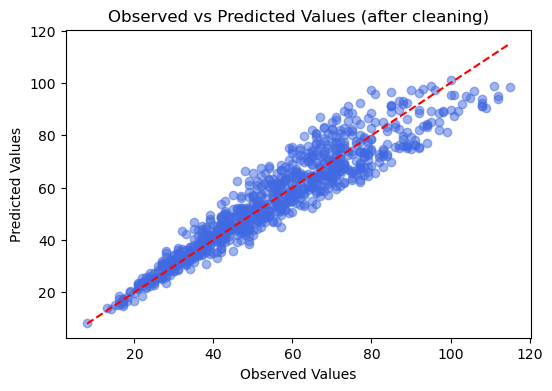

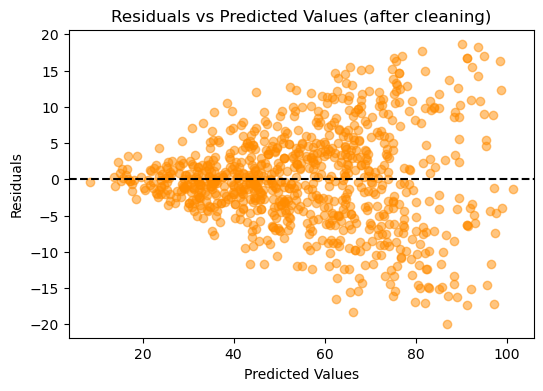

In [533]:
plt.figure(figsize=(6, 4))
plt.scatter(y, results.fittedvalues, alpha=0.5, color='royalblue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title('Observed vs Predicted Values (after cleaning)')
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(results.fittedvalues, results.resid, alpha=0.5, color='darkorange')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (after cleaning)')
plt.show()

However, from the _Residuals vs Predicted Values_ plot, we can observe a clear cone-shaped pattern, with residuals starting from 0 and ranging between -20 and +20.  
This pattern indicates heteroscedasticity, meaning the variance of the residuals increases as the predicted values grow.  
In other words, the model's error is not constant across all levels of prediction, but rather increases as the predicted values move further from 0.  
A solution to this phenomenon is to apply logarithmic or square root transformations to the model.  
These transformations stabilize the variance by compressing the scale of larger predicted values, making the residuals more homoscedastic and improving the model's assumptions.


Transformation: log


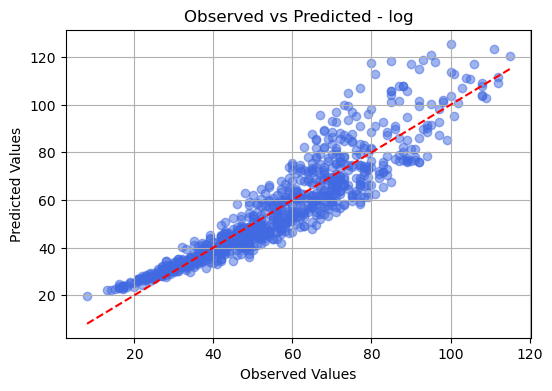

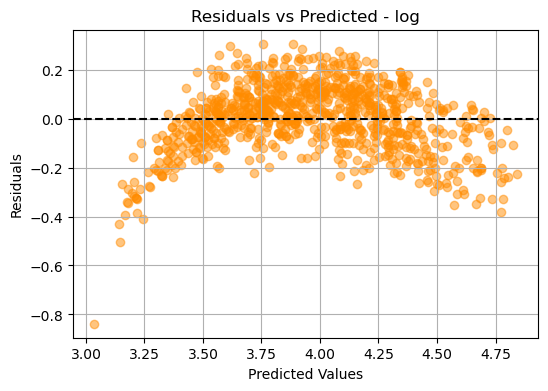


Transformation: sqrt


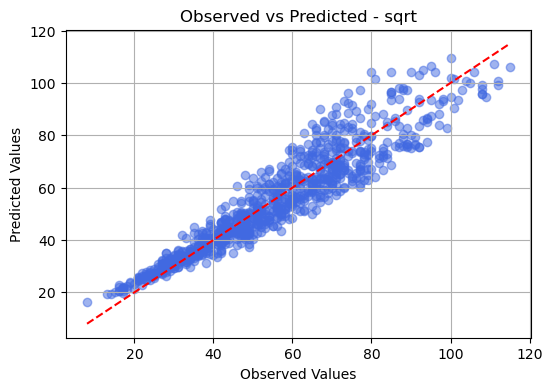

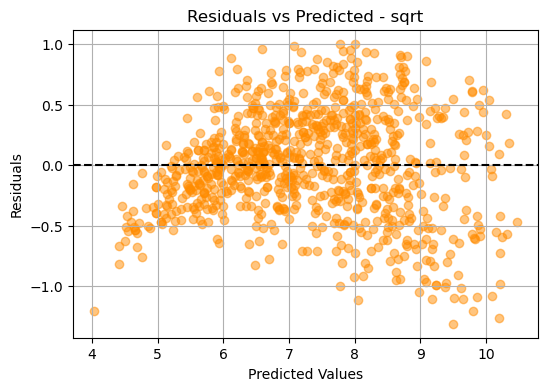


R² for each transformation:
log: 0.8815
sqrt: 0.9027


In [534]:
def transform_y(y, method):
    if method == 'log':
        return np.log1p(y)  
    elif method == 'sqrt':
        return np.sqrt(y)
    else:
        raise ValueError(f"Error")

transformations = ['log', 'sqrt']

results_summary = {}

categorical = ['Weather', 'Traffic_Level']
Food[categorical] = Food[categorical].astype('category')

model = MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Preparation_Time_min',
    'Courier_Experience_yrs',
])

X = model.fit_transform(Food)
y = Food['Delivery_Time_min']

for transform in transformations:
    print(f"\nTransformation: {transform}")

    y_transformed = transform_y(y, transform)
    
    mod = sm.OLS(y_transformed, X)
    res = mod.fit()

    results_summary[transform] = res.rsquared

    y_pred = res.predict(X)

    if transform == 'log':
        y_pred_plot = np.expm1(y_pred)
    elif transform == 'sqrt':
        y_pred_plot = np.square(y_pred)
    else:
        y_pred_plot = y_pred

    plt.figure(figsize=(6, 4))
    plt.scatter(y, y_pred_plot, alpha=0.5, color='royalblue')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
    plt.xlabel('Observed Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Observed vs Predicted - {transform}')
    plt.grid(True)
    plt.show()

    residuals = y_transformed - y_pred
    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred, residuals, color='darkorange', alpha=0.5)
    plt.axhline(y=0, color='k', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs Predicted - {transform}')
    plt.grid(True)
    plt.show()

print("\nR² for each transformation:")
for key, value in results_summary.items():
    print(f"{key}: {value:.4f}")


Observing the results from the plots, no clear improvement is noticeable.  
Moreover, the R² values are similar to the original model.  
Therefore, we prefer to continue our work with the non-transformed model.  


---

# Cross-Validation

Cross-validation helps evaluate how well the model generalizes to unseen data.  
By testing the model on a separate validation set, we can detect overfitting and assess real-world performance.  
In this case, we split the dataset into a training set _Food_train_ and a validation set _Food_valid_.  
We explicitly define the size of the validation set (430 samples), which is exactly half of the total dataset, to ensure a consistent and controlled evaluation.  


In [535]:
Food_train , Food_valid = train_test_split(Food, test_size=430, random_state=0) 

In [536]:
categorical = ['Weather', 'Traffic_Level']
Food_train[categorical] = Food_train[categorical].astype('category')

cv_model = MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Preparation_Time_min',
    'Courier_Experience_yrs',
])

X_train = cv_model.fit_transform(Food_train)
y_train = Food_train['Delivery_Time_min']


model = sm.OLS(y_train, X_train)
results = model.fit()

In [537]:
X_valid = cv_model.fit_transform(Food_valid)
y_valid = Food_valid['Delivery_Time_min']

valid_pred = results.predict(X_valid)
MSE = np.mean((y_valid - valid_pred)**2)
RMSE = np.sqrt(MSE)

print("MSE", MSE) 
print("RMSE", RMSE)

MSE 48.8813195529826
RMSE 6.991517685952214


- ## Leave-one-out cross-validation


In [538]:
categorical = ['Weather', 'Traffic_Level']
Food[categorical] = Food[categorical].astype('category')

loocv_model = sklearn_sm(sm.OLS, MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Preparation_Time_min',
    'Courier_Experience_yrs',
]))

X = Food.drop(columns=['Delivery_Time_min'])
y = Food['Delivery_Time_min']

cv_results = cross_validate(loocv_model, X, y, cv=Food.shape[0])
MSE = np.mean(cv_results['test_score'])
RMSE = np.sqrt(MSE)

print("MSE", MSE) 
print("RMSE", RMSE)


MSE 44.70860072334475
RMSE 6.686449036921223


Leave-one-out cross-validation is more precise but the most expensive in terms of both time and computation.  
This is because it requires the model to be trained multiple times, with each iteration leaving out a single data point for validation.  
Indeed, the results obtained in terms of MSE and RMSE were slightly improved compared to the previous cross-validation, but it took approximately 30 seconds, compared to 0 seconds for the previous method.


- ## K-fold cross-validation

In [539]:
categorical = ['Weather', 'Traffic_Level']
Food[categorical] = Food[categorical].astype('category')

kf_model = sklearn_sm(sm.OLS, MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Preparation_Time_min',
    'Courier_Experience_yrs',
]))

X = Food.drop(columns=['Delivery_Time_min'])
y = Food['Delivery_Time_min']

kf = KFold(n_splits=10, shuffle=True, random_state=1)
cv_results = cross_validate(kf_model, X, y, cv=kf)
MSE = np.mean(cv_results['test_score'])
RMSE = np.sqrt(MSE)

print("MSE", MSE) 
print("RMSE", RMSE)


MSE 45.05819307596635
RMSE 6.712539986917497


K-fold cross-validation strikes a balance between precision and computational cost.  
It involves splitting the dataset into k subsets, and iteratively training and validating the model on different combinations of these subsets.  
The results obtained from k-fold are positioned between those from the 50%-data cross-validation (which yielded slightly worse results) and the leave-one-out, which provided slightly better results.  
However, the execution time is much closer to that of the initial cross-validation, being far less computationally expensive than LOOCV.


---